# The Implementation of AE, VAE and GAN
This implementation includes the theoritical explamentation and training performance of three different kinds of generative deep learning models, that is, Autoencoder, Variational Autoencoder and Generative Adversarial Network on MNIST dataset. 

The questions will be covered are:
* Autoencoder: model introduction and implementation
* Variational Autoencoder: model introduction and implementation, theoritical explamentation
* The difference between Autoencoder and Variational Autoencoder
* Generative Adversarial Network: model introduction and implementation

**Note**: Models are created in Keras

## Part 3:  Generative Adversatral Network

#### Preparing:  Import TensorFlow and other libraries

In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from keras.datasets import mnist
import numpy as np
from keras import backend 
from keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout, Lambda,  UpSampling2D
from keras.models import Model
from keras.layers import Conv2DTranspose, Reshape,Activation, LeakyReLU, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
from plot import *
import datetime
import cv2

from IPython.display import display, Image, SVG

import warnings
warnings.filterwarnings('ignore')

#### Preparing:  Load the MNIST dataset
There are 60,000 MNIST image totally in the train set and 10,000 MNIST image totally in the test set. Each MNIST image is originally with shape (28, 28), each of which is between 0-255 and represents the intensity of a pixel. We normalize the images to the range (0, 1) and reshape them to (28, 28, 1)

In [26]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

### Introduction

GAN is a battle between two adversaries, the generator and the discriminator. The generator tries to convert random noise into observations that look as if they have been sampled from the original dataset and the disciminator tried to predict whether an observation comes from the original dataset or is one of the generators's forgeries. 


#### Parameters for training

In [27]:
SECTION = 'self_gan'
RUN_ID = '0001'
DATA_NAME = 'mini'
GAN_RUN_FOLDER = 'run/{}/'.format(SECTION)
GAN_RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(GAN_RUN_FOLDER):
    os.makedirs(GAN_RUN_FOLDER)
    os.makedirs(os.path.join(GAN_RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(GAN_RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(GAN_RUN_FOLDER, 'weights'))

    
input_dim = (28,28,1)
discriminator_conv_filters = [64,64,128,128]
discriminator_conv_kernel_size = [5,5,5,5]
discriminator_conv_strides = [2,2,2,1]

discriminator_activation = 'relu'
discriminator_dropout_rate = 0.4
discriminator_learning_rate = 0.0008
n_layers_discriminator = len(discriminator_conv_filters)
weight_init = RandomNormal(mean=0., stddev=0.02)

generator_initial_dense_layer_size = (7, 7, 64)
generator_upsample = [2,2, 1, 1]
generator_conv_filters = [128,64, 64,1]
generator_conv_kernel_size = [5,5,5,5]
generator_conv_strides = [1,1, 1, 1]
generator_batch_norm_momentum = 0.9

generator_activation = 'relu'
generator_dropout_rate = None
generator_learning_rate = 0.0004
n_layers_generator = len(generator_conv_filters)

optimiser = 'rmsprop'
z_dim = 100


BATCH_SIZE = 64
EPOCHS = 10
PRINT_EVERY_N_BATCHES = 5

#### Distriminator
To predict if an image is real or fake. 
* Input: image
* output: a single number between 0 and 1

The processes are as follows:
1. define the input 
2. stack convolutional layers on top of each other
3. flatten the last convolutional layer to a vector
4. dense layer of one unit by a sigmoid activation function that transforms the output from the dense layer to $[0,1]$

In [28]:
def get_activation(activation):
    if activation == 'leaky_relu':
        layer = LeakyReLU(alpha = 0.2)
    else:
        layer = Activation(activation)
    return layer

# define the input of image
discriminator_input = Input(shape=input_dim, name='discriminator_input')
x = discriminator_input
for i in range(n_layers_discriminator):
    x = Conv2D(
        filters = discriminator_conv_filters[i]
        , kernel_size = discriminator_conv_kernel_size[i]
        , strides = discriminator_conv_strides[i]
        , padding = 'same'
        , name = 'discriminator_conv_' + str(i+1)
        , kernel_initializer = weight_init
        )(x) 
    # x = BatchNormalization(momentum = discriminator_batch_norm_momentum)(x)
    # x = Dropout(rate = self.discriminator_dropout_rate)(x)
    x = get_activation(discriminator_activation)(x)
x = Flatten()(x)
# dense of one unit, with a sigmoid activation function that transforms the output from the dense layer to [0,1]
discriminator_output = Dense(1, activation='sigmoid', kernel_initializer = weight_init)(x)
# input: image, output: a single number between 0 and 1
discriminator = Model(discriminator_input, discriminator_output)

#### Generator 
The generator fulfills the same purpose as the decoder of a VAE: converting a vector in the latent sapce to an image. 
* Input: a vector, usually drawn from a multivariate standard normal distribution
* Output: an image of the same size in the original training data

The processes are as follows:
1. define the input 
2. follow with a Dense layer and a avtivative function, then reshaped to $[7,7,64]$
3. pass through four Conv2D layers
4. use a tanh activation to transform the output to the range $[-1,1]$, to match the original image domain. 


**Note**:
Unsampling layer: simply repeat each row and column of its input in order to double the size, then follow this with a normal convolutoinal layer with stride 1 to perform the convolution operation. Instead of filling the gaps between pixels with zeros, unsampling just repeats the existing pixel values. 

Conv2DTranspose method with stride 2: insert zero values in between pixels before performing the convolution operations. It can lead to artifacts, or small checkerboard patterns in the output image that spoil the quality of the ouput.

In [29]:
generator_input = Input(shape=(z_dim,), name='generator_input')
x = generator_input
x = Dense(np.prod(generator_initial_dense_layer_size), kernel_initializer = weight_init)(x)
# x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

x = get_activation(generator_activation)(x)
x = Reshape(generator_initial_dense_layer_size)(x)  #reshape to [7,7,64]
# x = Dropout(rate = self.generator_dropout_rate)(x)

for i in range(n_layers_generator):
    if generator_upsample[i] == 2:
        x = UpSampling2D()(x)
        x = Conv2D(
            filters = generator_conv_filters[i]
            , kernel_size = generator_conv_kernel_size[i]
            , padding = 'same'
            , name = 'generator_conv_' + str(i+1)
            , kernel_initializer = weight_init
        )(x)
    else:
        x = Conv2DTranspose(
            filters = generator_conv_filters[i]
            , kernel_size = generator_conv_kernel_size[i]
            , padding = 'same'
            , strides = generator_conv_strides[i]
            , name = 'generator_conv_' + str(i+1)
            , kernel_initializer = weight_init
            )(x)

    if i < n_layers_generator - 1:
        # x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
        x = get_activation(generator_activation)(x)
    else:
        # tansform the output to the range [-1, 1] to match the original image domain
        x = Activation('tanh')(x)
generator_output = x
# accept a vector of lenght 100 and output a tensor of shape [28, 28, 1]
generator = Model(generator_input, generator_output)

The training process: 
1. some of the images are randomly selected real observations from the training set and some are outputs from the generator; 
2. train the discriminator to learn how to tell the difference between the original and generated images, outputting value near fot the true images and values near 0 for the fake images. 
3. to train the generator, we connect it to the discriminator to create a Keras model. Feed the output from the generator into the discriminator so that the output from this combined model is the probability that the generated image is real, according to the discriminator. 

The loss function is the binary cross-entropy loss between the output from the discriminator and the response vector of 1. 

Freese the weights of the discriminator while we are training the combined model, so that only the generator's weights are updated. 

In [30]:
def set_trainable(m, val):
    m.trainable = val
    for l in m.layers:
        l.trainable = val

discriminator.compile(optimizer= RMSprop(lr=discriminator_learning_rate), loss = 'binary_crossentropy', 
                      metrics = ['accuracy'])

# freeze the discriminator weights
set_trainable(discriminator, False)

# input is a 100 dimensional latent vector, 
# passed through the generator and frozen discriminator to produce the output prob
model_input = Input(shape=(z_dim,), name='model_input')
model_output = discriminator(generator(model_input))
GAN_model = Model(model_input, model_output)

GAN_model.compile(optimizer=  RMSprop(lr=generator_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
set_trainable(discriminator, True)

In [8]:
# train the GAN by alternating training of the discriminator and generator 
def train_discriminator(x_train, batch_size):
    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(noise)
    
    # one batch update of the discriminator involves first training on a batch of true images with the response 1
    # on a batch of generated image with the response 0
    d_loss_real, d_acc_real =   discriminator.train_on_batch(true_imgs, valid)
    d_loss_fake, d_acc_fake =   discriminator.train_on_batch(gen_imgs, fake)
    d_loss =  0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)
    return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

def train_generator(batch_size):
    # on a batch of generated images with the response 1
    # the generator weights will move in the direction that allows it to better generate images to fool the discriminator
    valid = np.ones((batch_size,1))
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    return GAN_model.train_on_batch(noise, valid)


d_losses = []
g_losses = []
print_every_n_batches = 500

epochs = 1
iterations = int(x_train.shape[0] / BATCH_SIZE)
for epoch in range(epochs):

    for iteration in range(iterations):

        d = train_discriminator(x_train, BATCH_SIZE)
        g = train_generator(BATCH_SIZE)

        d_losses.append(d)
        g_losses.append(g)

        if iteration % print_every_n_batches == 0:
            print ("epoch %d iteration %d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, iteration, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))
            sample_images(GAN_RUN_FOLDER)
            GAN_model.save_weights(os.path.join(GAN_RUN_FOLDER, 'weights/weights-%d-%d.h5' % (epoch, iteration)))
            GAN_model.save_weights(os.path.join(GAN_RUN_FOLDER, 'weights/weights.h5'))

W1107 13:39:38.427284 139899691562816 deprecation_wrapper.py:119] From /home/zhuangby/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



epoch 0 iteration 0 [D loss: (0.720)(R 0.694, F 0.747)] [D acc: (0.164)(0.328, 0.000)] [G loss: 0.693] [G acc: 1.000]
epoch 0 iteration 500 [D loss: (0.409)(R 0.414, F 0.403)] [D acc: (0.836)(0.812, 0.859)] [G loss: 1.986] [G acc: 0.016]


### Result
The discriminator and generator will have found an equilibrium that allows the generator to learn meaningful information from the discriminator and the quality of the images will start to improve

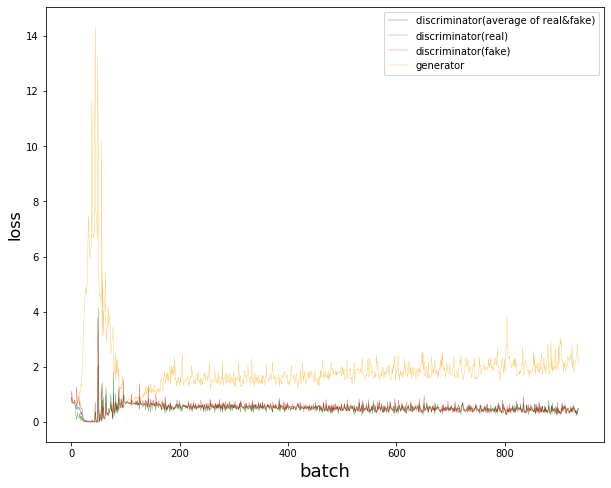

In [11]:
fig = plt.figure(figsize=(10, 8))
plt.plot([x[0] for x in d_losses], color='black', label = "discriminator(average of real&fake)", linewidth=0.25)

plt.plot([x[1] for x in d_losses], color='green', label = "discriminator(real)", linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', label = "discriminator(fake)", linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange',label = "generator", linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.legend()
#plt.xlim(0, 2000)
#plt.ylim(0, 2)

plt.show()

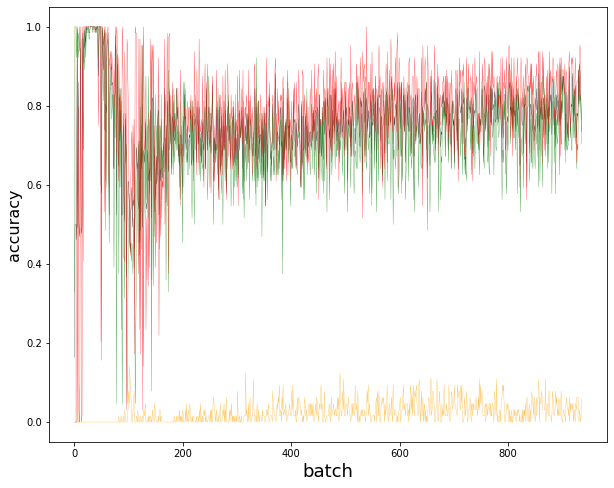

In [13]:
fig = plt.figure(figsize=(10, 8))
plt.plot([x[3] for x in d_losses], color='black', label = "discriminator(average of real&fake)", linewidth=0.25)
plt.plot([x[4] for x in d_losses], color='green',label = "discriminator(real)",  linewidth=0.25)
plt.plot([x[5] for x in d_losses], color='red',label = "discriminator(fake)", linewidth=0.25)
plt.plot([x[1] for x in g_losses], color='orange',label = "generator", linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

#plt.xlim(0, 2000)

plt.show()

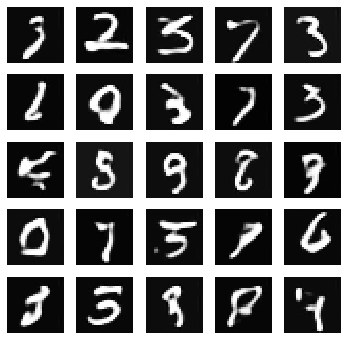

In [24]:
def sample_images( run_folder):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)

    fig, axs = plt.subplots(r, c, figsize=(6,6))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % epoch))
    plt.show()

sample_images(GAN_RUN_FOLDER)